# Symphony by Sequence: Learning to Compose with Neural Networks

## 1. RNN

In [ ]:
# Install & Configure Dependencies
!pip install --upgrade pip setuptools wheel >/dev/null
!pip install tensorflow pretty_midi midiutil kagglehub music21 jedi typeguard >/dev/null

import os, random
import numpy as np
import pretty_midi
import tensorflow as tf
from glob import glob
from midiutil import MIDIFile
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Embedding, GRU, Dropout, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
import matplotlib.pyplot as plt
import kagglehub
import os
from glob import glob
import numpy as np
import pretty_midi
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, GRU, Dropout, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
import matplotlib.pyplot as plt

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
ipython 7.34.0 requires jedi>=0.16, which is not installed.
  DEPRECATION: Building 'pretty_midi' using the legacy setup.py bdist_wheel mechanism, which will be removed in a future version. pip 25.3 will enforce this behaviour change. A possible replacement is to use the standardized build interface by setting the `--use-pep517` option, (possibly combined with `--no-build-isolation`), or adding a `pyproject.toml` file to the source tree of 'pretty_midi'. Discussion can be found at https://github.com/pypa/pip/issues/6334
  DEPRECATION: Building 'midiutil' using the legacy setup.py bdist_wheel mechanism, which will be removed in a future version. pip 25.3 will enforce this behaviour change. A possible replacement is to use the standardized build interface by setting the `--use-pep517` option, (possibly combined with

In [ ]:
# Download the classical-music-midi Dataset via Kagglehub
DATA_DIR = kagglehub.dataset_download("soumikrakshit/classical-music-midi")
print("Dataset directory:", DATA_DIR)

100%|██████████| 2.33M/2.33M [00:00<00:00, 3.82MB/s]

Extracting files...
Dataset directory: /root/.cache/kagglehub/datasets/soumikrakshit/classical-music-midi/versions/1


In [ ]:
# Parse MIDI Files into Time-Quantized Pitch Sequences
SEQ_LEN  = 32
all_vals = []
windows  = []

# Collecte every .mid/.midi file under DATA_DIR
midi_paths = glob(os.path.join(DATA_DIR, "**", "*.mid"), recursive=True) + \
             glob(os.path.join(DATA_DIR, "**", "*.midi"), recursive=True)

# Flatten all note‐on events from each file
for fn in midi_paths:
    try:
        pm         = pretty_midi.PrettyMIDI(fn)
        piano_roll = pm.get_piano_roll(fs=10)
        pitches, times = np.where(piano_roll > 0)
        order          = np.argsort(times)
        notes          = pitches[order]
        all_vals.extend(notes.tolist())
    except Exception:
        continue

# Build vocabulary mappings
v2i = {v: i for i, v in enumerate(sorted(set(all_vals)))}
i2v = {i: v for v, i in v2i.items()}

# Create sliding windows of integer indices
for i in range(len(all_vals) - SEQ_LEN):
    window = all_vals[i : i + SEQ_LEN]
    windows.append([v2i[note] for note in window])

# Assemble inputs X and sparse labels y
X = np.array(windows, dtype=np.int32)
y = np.array([v2i[all_vals[i + SEQ_LEN]] for i in range(len(windows))], dtype=np.int32)

print(f"Parsed {len(midi_paths)} files → {X.shape[0]} sequences, vocab size {len(v2i)}")
print("Pitch range:", min(i2v.values()), "to", max(i2v.values()))

Parsed 292 files → 2717427 sequences, vocab size 87
Pitch range: 21 to 107


In [ ]:
# Building and Compiling the RNN Model
EMBED_DIM = 64
RNN_UNITS = 256

model = Sequential([
    Embedding(
        input_dim=len(v2i),
        output_dim=EMBED_DIM,
        input_shape=(SEQ_LEN,)
    ),
    GRU(RNN_UNITS, return_sequences=True),
    Dropout(0.2),
    GRU(RNN_UNITS),
    Dropout(0.2),
    Dense(len(v2i), activation='softmax')
])

model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=Adam(learning_rate=0.001),
    metrics=['accuracy']
)

model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 32, 64)         │         5,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru (GRU)                       │ (None, 32, 256)        │       247,296 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 32, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_1 (GRU)                     │ (None, 256)            │       394,752 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 87)             │        22,359 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 669,975 (2.56 MB)

 Trainable params: 669,975 (2.56 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
19107/19107 ━━━━━━━━━━━━━━━━━━━━ 248s 13ms/step - accuracy: 0.1559 - loss: 2.9219 - val_accuracy: 0.2211 - val_loss: 2.7645 - learning_rate: 0.0010
Epoch 2/10
19107/19107 ━━━━━━━━━━━━━━━━━━━━ 252s 13ms/step - accuracy: 0.2505 - loss: 2.5239 - val_accuracy: 0.2437 - val_loss: 2.6811 - learning_rate: 0.0010
Epoch 3/10
19107/19107 ━━━━━━━━━━━━━━━━━━━━ 261s 13ms/step - accuracy: 0.2764 - loss: 2.4356 - val_accuracy: 0.2553 - val_loss: 2.6267 - learning_rate: 0.0010
Epoch 4/10
19107/19107 ━━━━━━━━━━━━━━━━━━━━ 254s 13ms/step - accuracy: 0.2915 - loss: 2.3731 - val_accuracy: 0.2606 - val_loss: 2.5900 - learning_rate: 0.0010
Epoch 5/10
19107/19107 ━━━━━━━━━━━━━━━━━━━━ 246s 13ms/step - accuracy: 0.3003 - loss: 2.3317 - val_accuracy: 0.2630 - val_loss: 2.5794 - learning_rate: 0.0010
Epoch 6/10
19107/19107 ━━━━━━━━━━━━━━━━━━━━ 256s 13ms/step - accuracy: 0.3052 - loss: 2.3058 - val_accuracy: 0.2650 - val_loss: 2.5560 - learning_rate: 0.0010
Epoch 7/10
19107/19107 ━━━━━━━━━━━━━━━━━━━━ 23

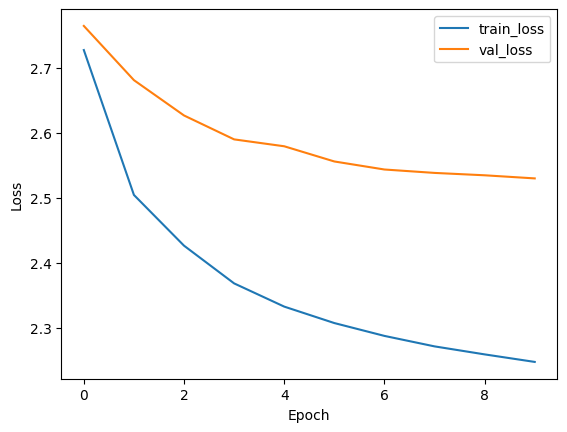

In [ ]:
# Callbacks and Training
callbacks = [
    EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2),
    ModelCheckpoint('best_classical_model.keras', monitor='val_loss', save_best_only=True),
]

history = model.fit(
    X, y,
    validation_split=0.1,
    epochs=10,
    batch_size=128,
    callbacks=callbacks,
    shuffle=True
)

# plotting training & validation loss
plt.plot(history.history['loss'],  label='train_loss')
plt.plot(history.history['val_loss'],label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
# Sample Helper & Generate New MIDI
from midiutil import MIDIFile
import random

def sample_with_temperature(preds, temperature=1.0):
    preds = np.log(preds + 1e-8) / temperature
    exp_preds = np.exp(preds)
    p = exp_preds / np.sum(exp_preds)
    return np.random.choice(len(p), p=p)

# Prime with a random seed window
start_idx = random.randint(0, len(windows)-1)
seed_seq   = windows[start_idx].copy()
generated  = seed_seq.copy()

for _ in range(200):
    input_seq = np.array(seed_seq[-SEQ_LEN:])[None, :]
    preds     = model.predict(input_seq)[0]
    next_i    = sample_with_temperature(preds, temperature=0.8)
    generated.append(next_i)
    seed_seq.append(next_i)

# Writing to MIDI
midi = MIDIFile(1)
track, time, channel = 0, 0, 0
duration, volume     = 0.5, 100
midi.addTrackName(track, time, "Generated")
midi.addTempo(track, time, 120)

for note_i in generated:
    pitch = i2v[note_i]
    midi.addNote(track, channel, pitch, time, duration, volume)
    time += duration

with open("RNN_generated_classical.mid", "wb") as outf:
    midi.writeFile(outf)

print("Wrote RNN_generated_classical.mid")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━

In [ ]:
# Polyphony with Single Generation Pass
from midiutil import MIDIFile
import random
import numpy as np
from tensorflow.keras.models import load_model

# Reloading model & mappings
model = load_model('best_classical_model.keras')

# Sampling helper
def sample_with_temperature(preds, temperature=1.0):
    preds = np.log(preds + 1e-8) / temperature
    exp_preds = np.exp(preds)
    p = exp_preds / np.sum(exp_preds)
    return np.random.choice(len(p), p=p)

# Monophonic generation
start_idx = random.randint(0, len(windows) - 1)
seed_seq  = windows[start_idx].copy()
generated = seed_seq.copy()

for _ in range(200):
    input_seq = np.array(seed_seq[-SEQ_LEN:])[None, :]
    preds     = model.predict(input_seq, verbose=0)[0]
    next_i    = sample_with_temperature(preds, temperature=0.8)
    generated.append(next_i)
    seed_seq.append(next_i)

# Settingup  MIDIFile
INSTRUMENTS = [0, 0, 0]
TEMPOS      = [120, 100, 80]
TRACKS      = len(INSTRUMENTS)

midi = MIDIFile(TRACKS)
for t in range(TRACKS):
    midi.addTrackName(t, 0, f"Track {t}")
    midi.addTempo(t, 0, TEMPOS[t])
    midi.addProgramChange(t, t, 0, INSTRUMENTS[t])

duration = 0.5
volume   = 100

# Writing to MIDI
for idx, note_i in enumerate(generated):
    t = idx * duration

    # Track 0: straight melody
    midi.addNote(0, 0, i2v[note_i], t, duration, volume)

    # Track 1: bass line (every 4th note, one octave lower)
    if idx % 4 == 0:
        midi.addNote(1, 1, i2v[note_i] - 12, t, duration, volume)

    # Track 2: simple triad chords on every note
    root = i2v[note_i]
    for interv in (0, 4, 7):
        midi.addNote(2, 2, root + interv, t, duration, int(volume * 0.8))

# Write out the MIDI file
with open("RNN_generated_classical_2.mid", "wb") as f:
    midi.writeFile(f)

print("Wrote RNN_generated_classical_2.mid")

Wrote RNN_generated_classical_2.mid


In [ ]:
import numpy as np
import random
from midiutil import MIDIFile

# Setting random seeds to None
np.random.seed(None)
random.seed(None)

def sample_with_temperature(preds, temperature=1.0):
    preds = np.log(preds + 1e-8) / temperature
    exp_preds = np.exp(preds)
    p = exp_preds / np.sum(exp_preds)
    return np.random.choice(len(p), p=p)

def generate_music(model, seed_seq, length, temperature):
    seed_seq = seed_seq[-SEQ_LEN:]
    generated = seed_seq.copy()

    for _ in range(length):
        input_seq = np.array(seed_seq)[None, :]
        preds = model.predict(input_seq, verbose=0)[0]
        next_i = sample_with_temperature(preds, temperature)
        generated.append(next_i)

        seed_seq = seed_seq[1:] + [next_i]

    return generated

def save_midi(note_indices, i2v, filename="generated.mid"):
    midi = MIDIFile(1)
    track, time, channel = 0, 0, 0
    duration, volume = 0.5, 100

    midi.addTrackName(track, time, "Generated")
    midi.addTempo(track, time, 120)

    for idx in note_indices:
        pitch = i2v[idx]
        midi.addNote(track, channel, pitch, time, duration, volume)
        time += duration

    with open(filename, "wb") as outf:
        midi.writeFile(outf)

start_idx = random.randint(0, len(windows) - 1)
seed_seq = windows[start_idx].copy()

# Generating for multiple temperatures
for temp in [0.7, 0.8, 0.9, 1.0]:
    print(f"Generating with temperature={temp}")
    seed = seed_seq.copy()
    generated_indices = generate_music(model, seed, length=200, temperature=temp)
    save_midi(generated_indices, i2v, filename=f"RNN_generated_temp_{temp}.mid")
    print(f"Saved: RNN_generated_temp_{temp}.mid")

Generating with temperature=0.7
Saved: RNN_generated_temp_0.7.mid
Generating with temperature=0.8
Saved: RNN_generated_temp_0.8.mid
Generating with temperature=0.9
Saved: RNN_generated_temp_0.9.mid
Generating with temperature=1.0
Saved: RNN_generated_temp_1.0.mid


## 2. LSTM

In [ ]:
# Install & Configure Dependencies
!pip install --upgrade pip setuptools wheel >/dev/null
!pip install tensorflow pretty_midi midiutil kagglehub music21 jedi typeguard >/dev/null

import os, random
import numpy as np
import pretty_midi
import tensorflow as tf
from glob import glob
from midiutil import MIDIFile
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Embedding, GRU, Dropout, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
import matplotlib.pyplot as plt
import kagglehub
import os
from glob import glob
import numpy as np
import pretty_midi
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, GRU, Dropout, Dense, LSTM
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
import matplotlib.pyplot as plt

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
ipython 7.34.0 requires jedi>=0.16, which is not installed.
  DEPRECATION: Building 'pretty_midi' using the legacy setup.py bdist_wheel mechanism, which will be removed in a future version. pip 25.3 will enforce this behaviour change. A possible replacement is to use the standardized build interface by setting the `--use-pep517` option, (possibly combined with `--no-build-isolation`), or adding a `pyproject.toml` file to the source tree of 'pretty_midi'. Discussion can be found at https://github.com/pypa/pip/issues/6334
  DEPRECATION: Building 'midiutil' using the legacy setup.py bdist_wheel mechanism, which will be removed in a future version. pip 25.3 will enforce this behaviour change. A possible replacement is to use the standardized build interface by setting the `--use-pep517` option, (possibly combined with

In [ ]:
# Download the classical-music-midi Dataset via Kagglehub
DATA_DIR = kagglehub.dataset_download("soumikrakshit/classical-music-midi")
print("Dataset directory:", DATA_DIR)

Dataset directory: /kaggle/input/classical-music-midi


In [ ]:
# Parse MIDI Files into Time-Quantized Pitch Sequences
SEQ_LEN  = 32
all_vals = []
windows  = []

# Collect every .mid/.midi file under DATA_DIR
midi_paths = glob(os.path.join(DATA_DIR, "**", "*.mid"), recursive=True) + \
             glob(os.path.join(DATA_DIR, "**", "*.midi"), recursive=True)

# Flatten all note‐on events from each file
for fn in midi_paths:
    try:
        pm         = pretty_midi.PrettyMIDI(fn)
        piano_roll = pm.get_piano_roll(fs=10)
        pitches, times = np.where(piano_roll > 0)
        order          = np.argsort(times)
        notes          = pitches[order]
        all_vals.extend(notes.tolist())
    except Exception:
        continue

# Build vocabulary mappings
v2i = {v: i for i, v in enumerate(sorted(set(all_vals)))}
i2v = {i: v for v, i in v2i.items()}

# Create sliding windows of integer indices
for i in range(len(all_vals) - SEQ_LEN):
    window = all_vals[i : i + SEQ_LEN]
    windows.append([v2i[note] for note in window])

# Assemble inputs X and sparse labels y
X = np.array(windows, dtype=np.int32)
y = np.array([v2i[all_vals[i + SEQ_LEN]] for i in range(len(windows))], dtype=np.int32)

print(f"Parsed {len(midi_paths)} files → {X.shape[0]} sequences, vocab size {len(v2i)}")
print("Pitch range:", min(i2v.values()), "to", max(i2v.values()))

Parsed 292 files → 2717427 sequences, vocab size 87
Pitch range: 21 to 107


In [ ]:
# Build and Compile the LSTM Model
# Define vocab_size and sequence length
vocab_size = len(v2i)
SEQ_LEN    = 32

print(f"SEQ_LEN = {SEQ_LEN}, vocab_size = {vocab_size}")

# Hyperparameters
embedding_dim = 64
hidden_units  = 256

# Building model
model = Sequential([
    Embedding(input_dim=vocab_size,
              output_dim=embedding_dim,
              input_shape=(SEQ_LEN,)),
    LSTM(hidden_units, return_sequences=True),
    Dropout(0.2),
    LSTM(hidden_units),
    Dense(vocab_size, activation="softmax"),
])

# Compiling
model.compile(
    loss="categorical_crossentropy",
    optimizer=Adam(learning_rate=1e-3),
    metrics=["accuracy"],
)

model.summary()

SEQ_LEN = 32, vocab_size = 87


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 32, 64)         │         5,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 32, 256)        │       328,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 32, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 256)            │       525,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 87)             │        22,359 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 881,943 (3.36 MB)

 Trainable params: 881,943 (3.36 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
19107/19107 ━━━━━━━━━━━━━━━━━━━━ 272s 14ms/step - accuracy: 0.1619 - loss: 2.9336 - val_accuracy: 0.2148 - val_loss: 2.7124 - learning_rate: 0.0010
Epoch 2/10
19107/19107 ━━━━━━━━━━━━━━━━━━━━ 269s 14ms/step - accuracy: 0.2711 - loss: 2.4257 - val_accuracy: 0.2338 - val_loss: 2.6434 - learning_rate: 0.0010
Epoch 3/10
19107/19107 ━━━━━━━━━━━━━━━━━━━━ 262s 14ms/step - accuracy: 0.2928 - loss: 2.3342 - val_accuracy: 0.2419 - val_loss: 2.6090 - learning_rate: 0.0010
Epoch 4/10
19107/19107 ━━━━━━━━━━━━━━━━━━━━ 269s 14ms/step - accuracy: 0.3059 - loss: 2.2745 - val_accuracy: 0.2468 - val_loss: 2.5967 - learning_rate: 0.0010
Epoch 5/10
19107/19107 ━━━━━━━━━━━━━━━━━━━━ 269s 14ms/step - accuracy: 0.3153 - loss: 2.2280 - val_accuracy: 0.2534 - val_loss: 2.5719 - learning_rate: 0.0010
Epoch 6/10
19107/19107 ━━━━━━━━━━━━━━━━━━━━ 322s 14ms/step - accuracy: 0.3223 - loss: 2.1945 - val_accuracy: 0.2545 - val_loss: 2.5680 - learning_rate: 0.0010
Epoch 7/10
19107/19107 ━━━━━━━━━━━━━━━━━━━━ 26

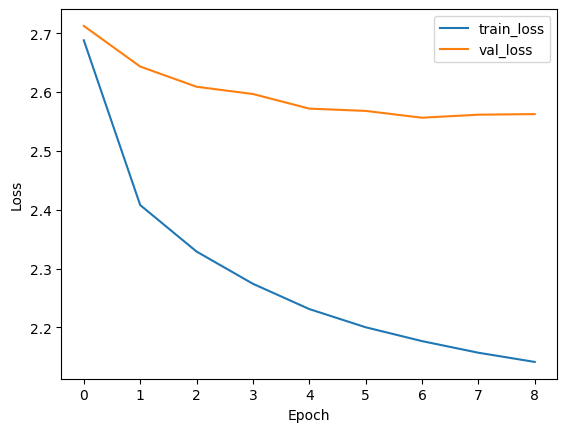

In [ ]:
# Callbacks, Compilation with Sparse Categorical Crossentropy & Training
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt

# Define callbacks
callbacks = [
    EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2),
    ModelCheckpoint('best_classical_model.keras', monitor='val_loss', save_best_only=True),
]

# Compile model using sparse categorical crossentropy
model.compile(
    loss="sparse_categorical_crossentropy",
    optimizer=Adam(learning_rate=1e-3),
    metrics=["accuracy"],
)

# Training
history = model.fit(
    X, y,
    validation_split=0.1,
    epochs=10,
    batch_size=128,
    callbacks=callbacks,
    shuffle=True
)

# Plot training & validation loss
plt.plot(history.history['loss'],  label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
# Sample Helper & Generate New MIDI
from midiutil import MIDIFile
import random

def sample_with_temperature(preds, temperature=1.0):
    preds = np.log(preds + 1e-8) / temperature
    exp_preds = np.exp(preds)
    p = exp_preds / np.sum(exp_preds)
    return np.random.choice(len(p), p=p)

# Prime with a Random Seed Window
start_idx = random.randint(0, len(windows)-1)
seed_seq   = windows[start_idx].copy()
generated  = seed_seq.copy()

for _ in range(200):
    input_seq = np.array(seed_seq[-SEQ_LEN:])[None, :]
    preds     = model.predict(input_seq)[0]
    next_i    = sample_with_temperature(preds, temperature=0.8)
    generated.append(next_i)
    seed_seq.append(next_i)

# Write to MIDI
midi = MIDIFile(1)
track, time, channel = 0, 0, 0
duration, volume     = 0.5, 100
midi.addTrackName(track, time, "Generated")
midi.addTempo(track, time, 120)

for note_i in generated:
    pitch = i2v[note_i]
    midi.addNote(track, channel, pitch, time, duration, volume)
    time += duration

with open("LSTM_generated_classical.mid", "wb") as outf:
    midi.writeFile(outf)

print("Wrote LSTM_generated_classical.mid")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 240ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━

In [ ]:
# Polyphony with Single Generation Pass
from midiutil import MIDIFile
import random
import numpy as np
from tensorflow.keras.models import load_model

# Reloading model & mappings
model = load_model('best_classical_model.keras')

# Sampling helper
def sample_with_temperature(preds, temperature=1.0):
    preds = np.log(preds + 1e-8) / temperature
    exp_preds = np.exp(preds)
    p = exp_preds / np.sum(exp_preds)
    return np.random.choice(len(p), p=p)

# Monophonic generation
start_idx = random.randint(0, len(windows) - 1)
seed_seq  = windows[start_idx].copy()
generated = seed_seq.copy()

for _ in range(200):
    input_seq = np.array(seed_seq[-SEQ_LEN:])[None, :]
    preds     = model.predict(input_seq, verbose=0)[0]
    next_i    = sample_with_temperature(preds, temperature=0.8)
    generated.append(next_i)
    seed_seq.append(next_i)

# Settingup  MIDIFile
INSTRUMENTS = [0, 0, 0]
TEMPOS      = [120, 100, 80]
TRACKS      = len(INSTRUMENTS)

midi = MIDIFile(TRACKS)
for t in range(TRACKS):
    midi.addTrackName(t, 0, f"Track {t}")
    midi.addTempo(t, 0, TEMPOS[t])
    midi.addProgramChange(t, t, 0, INSTRUMENTS[t])

duration = 0.5
volume   = 100

# Write to MIDI
for idx, note_i in enumerate(generated):
    t = idx * duration

    # Track 0: straight melody
    midi.addNote(0, 0, i2v[note_i], t, duration, volume)

    # Track 1: bass line
    if idx % 4 == 0:
        midi.addNote(1, 1, i2v[note_i] - 12, t, duration, volume)

    # Track 2: simple triad chords on every note
    root = i2v[note_i]
    for interv in (0, 4, 7):
        midi.addNote(2, 2, root + interv, t, duration, int(volume * 0.8))

# Write out the MIDI file
with open("LSTM_generated_classical_2.mid", "wb") as f:
    midi.writeFile(f)

print("Wrote LSTM_generated_classical_2.mid")

Wrote LSTM_generated_classical_2.mid


In [ ]:
import numpy as np
import random
from midiutil import MIDIFile

# Setting random seeds to None
np.random.seed(None)
random.seed(None)

def sample_with_temperature(preds, temperature=1.0):
    preds = np.log(preds + 1e-8) / temperature
    exp_preds = np.exp(preds)
    p = exp_preds / np.sum(exp_preds)
    return np.random.choice(len(p), p=p)

def generate_music(model, seed_seq, length, temperature):
    seed_seq = seed_seq[-SEQ_LEN:]
    generated = seed_seq.copy()

    for _ in range(length):
        input_seq = np.array(seed_seq)[None, :]
        preds = model.predict(input_seq, verbose=0)[0]
        next_i = sample_with_temperature(preds, temperature)
        generated.append(next_i)

        seed_seq = seed_seq[1:] + [next_i]

    return generated

def save_midi(note_indices, i2v, filename="generated.mid"):
    midi = MIDIFile(1)
    track, time, channel = 0, 0, 0
    duration, volume = 0.5, 100

    midi.addTrackName(track, time, "Generated")
    midi.addTempo(track, time, 120)

    for idx in note_indices:
        pitch = i2v[idx]
        midi.addNote(track, channel, pitch, time, duration, volume)
        time += duration

    with open(filename, "wb") as outf:
        midi.writeFile(outf)

start_idx = random.randint(0, len(windows) - 1)
seed_seq = windows[start_idx].copy()

# Generate for multiple temperatures
for temp in [0.7, 0.8, 0.9, 1.0]:
    print(f"Generating with temperature={temp}")
    seed = seed_seq.copy()
    generated_indices = generate_music(model, seed, length=200, temperature=temp)
    save_midi(generated_indices, i2v, filename=f"LSTM_generated_temp_{temp}.mid")
    print(f"Saved: LSTM_generated_temp_{temp}.mid")

Generating with temperature=0.7
Saved: LSTM_generated_temp_0.7.mid
Generating with temperature=0.8
Saved: LSTM_generated_temp_0.8.mid
Generating with temperature=0.9
Saved: LSTM_generated_temp_0.9.mid
Generating with temperature=1.0
Saved: LSTM_generated_temp_1.0.mid


## 3. Transformer

In [ ]:
# Install & Configure Dependencies
!pip install --upgrade pip setuptools wheel >/dev/null
!pip install tensorflow pretty_midi midiutil kagglehub music21 jedi typeguard >/dev/null

import os, random
import numpy as np
import pretty_midi
import tensorflow as tf
from glob import glob
from midiutil import MIDIFile
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Embedding, GRU, Dropout, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
import matplotlib.pyplot as plt
import kagglehub
import os
from glob import glob
import numpy as np
import pretty_midi
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, GRU, Dropout, Dense, LSTM
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
import matplotlib.pyplot as plt

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
ipython 7.34.0 requires jedi>=0.16, which is not installed.
  DEPRECATION: Building 'pretty_midi' using the legacy setup.py bdist_wheel mechanism, which will be removed in a future version. pip 25.3 will enforce this behaviour change. A possible replacement is to use the standardized build interface by setting the `--use-pep517` option, (possibly combined with `--no-build-isolation`), or adding a `pyproject.toml` file to the source tree of 'pretty_midi'. Discussion can be found at https://github.com/pypa/pip/issues/6334
  DEPRECATION: Building 'midiutil' using the legacy setup.py bdist_wheel mechanism, which will be removed in a future version. pip 25.3 will enforce this behaviour change. A possible replacement is to use the standardized build interface by setting the `--use-pep517` option, (possibly combined with

In [ ]:
# Download the classical-music-midi Dataset via Kagglehub
DATA_DIR = kagglehub.dataset_download("soumikrakshit/classical-music-midi")
print("Dataset directory:", DATA_DIR)

Dataset directory: /kaggle/input/classical-music-midi


In [ ]:
# Parsing MIDI Files into Time-Quantized Pitch Sequences
SEQ_LEN  = 32
all_vals = []
windows  = []

# Collect every .mid/.midi file under DATA_DIR
midi_paths = glob(os.path.join(DATA_DIR, "**", "*.mid"), recursive=True) + \
             glob(os.path.join(DATA_DIR, "**", "*.midi"), recursive=True)

# Flatten all note‐on events from each file
for fn in midi_paths:
    try:
        pm         = pretty_midi.PrettyMIDI(fn)
        piano_roll = pm.get_piano_roll(fs=10)
        pitches, times = np.where(piano_roll > 0)
        order          = np.argsort(times)
        notes          = pitches[order]
        all_vals.extend(notes.tolist())
    except Exception:
        continue

# Build vocabulary mappings
v2i = {v: i for i, v in enumerate(sorted(set(all_vals)))}
i2v = {i: v for v, i in v2i.items()}

# Create sliding windows of integer indices
for i in range(len(all_vals) - SEQ_LEN):
    window = all_vals[i : i + SEQ_LEN]
    windows.append([v2i[note] for note in window])

# Assemble inputs X and sparse labels y
X = np.array(windows, dtype=np.int32)
y = np.array([v2i[all_vals[i + SEQ_LEN]] for i in range(len(windows))], dtype=np.int32)

print(f"Parsed {len(midi_paths)} files → {X.shape[0]} sequences, vocab size {len(v2i)}")
print("Pitch range:", min(i2v.values()), "to", max(i2v.values()))

Parsed 292 files → 2717427 sequences, vocab size 87
Pitch range: 21 to 107


In [ ]:
import tensorflow as tf
from tensorflow.keras import layers

# Positional Encoding Layer
class PositionalEncoding(tf.keras.layers.Layer):
    def __init__(self, seq_len, d_model):
        super().__init__()
        pos_encoding = self._get_positional_encoding(seq_len, d_model)
        self.pos_encoding = tf.constant(pos_encoding[np.newaxis, ...], dtype=tf.float32)

    def _get_positional_encoding(self, seq_len, d_model):
        pos = np.arange(seq_len)[:, np.newaxis]
        i = np.arange(d_model)[np.newaxis, :]
        angle_rates = 1 / np.power(10000, (2 * (i//2)) / np.float32(d_model))
        angle_rads = pos * angle_rates
        angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])
        angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])
        return angle_rads

    def call(self, x):
        return x + self.pos_encoding[:, :tf.shape(x)[1], :]

In [ ]:
def transformer_block(x, head_size, num_heads, ff_dim, dropout=0.1):
    attn = layers.MultiHeadAttention(num_heads=num_heads, key_dim=head_size)(x, x)
    attn = layers.Dropout(dropout)(attn)
    x = layers.LayerNormalization(epsilon=1e-6)(x + attn)
    ffn = tf.keras.Sequential([
        layers.Dense(ff_dim, activation="relu"),
        layers.Dense(x.shape[-1])
    ])
    ffn_output = ffn(x)
    ffn_output = layers.Dropout(dropout)(ffn_output)
    return layers.LayerNormalization(epsilon=1e-6)(x + ffn_output)

def build_transformer_model(seq_len, vocab_size, d_model=128, num_heads=4, ff_dim=256, num_layers=2):
    inputs = layers.Input(shape=(seq_len,))
    x = layers.Embedding(vocab_size, d_model)(inputs)
    x = PositionalEncoding(seq_len, d_model)(x)

    for _ in range(num_layers):
        x = transformer_block(x, d_model, num_heads, ff_dim)

    x = layers.GlobalAveragePooling1D()(x)
    x = layers.Dense(256, activation="relu")(x)
    x = layers.Dropout(0.2)(x)
    outputs = layers.Dense(vocab_size, activation="softmax")(x)

    return tf.keras.Model(inputs, outputs)

vocab_size = len(v2i)
SEQ_LEN = 32  # use the same as before
model = build_transformer_model(SEQ_LEN, vocab_size)

model.compile(
    loss="sparse_categorical_crossentropy",
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    metrics=["accuracy"]
)

model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 32)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 32, 128)   │     11,136 │ input_layer[0][0] │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ positional_encoding │ (None, 32, 128)   │          0 │ embedding[0][0]   │
│ (PositionalEncodin… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 32, 128)   │    263,808 │ positional_encod… │
│ (MultiHeadAttentio… │                   │            │ positional_encod… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 32, 128)   │          0 │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 32, 128)   │          0 │ positional_encod… │
│                     │                   │            │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalization │ (None, 32, 128)   │        256 │ add[0][0]         │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential          │ (None, 32, 128)   │     65,920 │ layer_normalizat… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 32, 128)   │          0 │ sequential[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 32, 128)   │          0 │ layer_normalizat… │
│                     │                   │            │ dropout_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 32, 128)   │        256 │ add_1[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 32, 128)   │    263,808 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_4 (Dropout) │ (None, 32, 128)   │          0 │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_2 (Add)         │ (None, 32, 128)   │          0 │ layer_normalizat… │
│                     │                   │            │ dropout_4[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 32, 128)   │        256 │ add_2[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_1        │ (None, 32, 128)   │     65,920 │ layer_normalizat… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_5 (Dropout) │ (None, 32, 128)   │          0 │ sequential_1[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_3 (Add)         │ (None, 32, 128)   │          0 │ layer_normalizat… │
│                     │                   │            │ dropout_5[0][0] 

 Total params: 726,999 (2.77 MB)

 Trainable params: 726,999 (2.77 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
4777/4777 ━━━━━━━━━━━━━━━━━━━━ 267s 53ms/step - accuracy: 0.1293 - loss: 3.0771 - val_accuracy: 0.1547 - val_loss: 2.8532 - learning_rate: 0.0010
Epoch 2/50
4777/4777 ━━━━━━━━━━━━━━━━━━━━ 251s 52ms/step - accuracy: 0.1964 - loss: 2.6531 - val_accuracy: 0.2205 - val_loss: 2.7056 - learning_rate: 0.0010
Epoch 3/50
4777/4777 ━━━━━━━━━━━━━━━━━━━━ 260s 52ms/step - accuracy: 0.2535 - loss: 2.5238 - val_accuracy: 0.2435 - val_loss: 2.6329 - learning_rate: 0.0010
Epoch 4/50
4777/4777 ━━━━━━━━━━━━━━━━━━━━ 262s 52ms/step - accuracy: 0.2695 - loss: 2.4755 - val_accuracy: 0.2510 - val_loss: 2.6144 - learning_rate: 0.0010
Epoch 5/50
4777/4777 ━━━━━━━━━━━━━━━━━━━━ 249s 52ms/step - accuracy: 0.2779 - loss: 2.4510 - val_accuracy: 0.2555 - val_loss: 2.5808 - learning_rate: 0.0010
Epoch 6/50
4777/4777 ━━━━━━━━━━━━━━━━━━━━ 266s 53ms/step - accuracy: 0.2828 - loss: 2.4363 - val_accuracy: 0.2572 - val_loss: 2.5736 - learning_rate: 0.0010
Epoch 7/50
4777/4777 ━━━━━━━━━━━━━━━━━━━━ 262s 53ms/step -

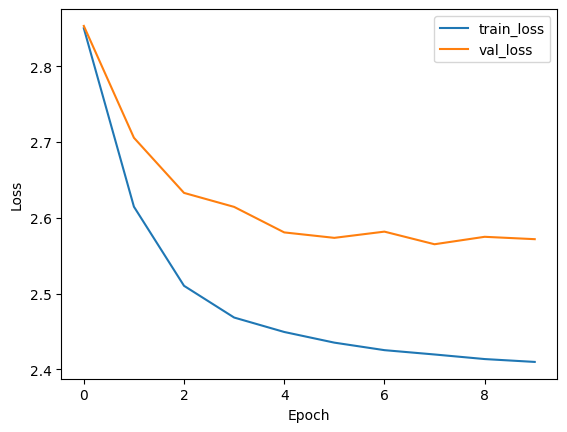

In [ ]:
# Callbacks, Compilation with Sparse Categorical Crossentropy & Training
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt

# Define callbacks
callbacks = [
    EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2),
    ModelCheckpoint('best_classical_model.keras', monitor='val_loss', save_best_only=True),
]

# Compile model using sparse categorical crossentropy
model.compile(
    loss="sparse_categorical_crossentropy",
    optimizer=Adam(learning_rate=1e-3),
    metrics=["accuracy"],
)

# Training
history = model.fit(
    X, y,
    validation_split=0.1,
    epochs=50,
    batch_size=512,
    callbacks=callbacks,
    shuffle=True
)

# Plot training & validation loss
plt.plot(history.history['loss'],  label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
import numpy as np
import random
from midiutil import MIDIFile

# Setting random seeds to None
np.random.seed(None)
random.seed(None)

def sample_with_temperature(preds, temperature=1.0):
    preds = np.log(preds + 1e-8) / temperature
    exp_preds = np.exp(preds)
    p = exp_preds / np.sum(exp_preds)
    return np.random.choice(len(p), p=p)

def generate_music(model, seed_seq, length, temperature):
    seed_seq = seed_seq[-SEQ_LEN:]
    generated = seed_seq.copy()

    for _ in range(length):
        input_seq = np.array(seed_seq)[None, :]
        preds = model.predict(input_seq, verbose=0)[0]
        next_i = sample_with_temperature(preds, temperature)
        generated.append(next_i)

        seed_seq = seed_seq[1:] + [next_i]

    return generated

def save_midi(note_indices, i2v, filename="generated.mid"):
    midi = MIDIFile(1)
    track, time, channel = 0, 0, 0
    duration, volume = 0.5, 100

    midi.addTrackName(track, time, "Generated")
    midi.addTempo(track, time, 120)

    for idx in note_indices:
        pitch = i2v[idx]
        midi.addNote(track, channel, pitch, time, duration, volume)
        time += duration

    with open(filename, "wb") as outf:
        midi.writeFile(outf)
start_idx = random.randint(0, len(windows) - 1)
seed_seq = windows[start_idx].copy()

for temp in [0.7, 0.8, 0.9, 1.0]:
    print(f"Generating with temperature={temp}")
    seed = seed_seq.copy()
    generated_indices = generate_music(model, seed, length=200, temperature=temp)
    save_midi(generated_indices, i2v, filename=f"Transformer_generated_temp_{temp}.mid")
    print(f"Saved: Transformer_generated_temp_{temp}.mid")

Generating with temperature=0.7
Saved: Transformer_generated_temp_0.7.mid
Generating with temperature=0.8
Saved: Transformer_generated_temp_0.8.mid
Generating with temperature=0.9
Saved: Transformer_generated_temp_0.9.mid
Generating with temperature=1.0
Saved: Transformer_generated_temp_1.0.mid


In [ ]:
# Sampling Helper & Generating New MIDI
from midiutil import MIDIFile
import random

def sample_with_temperature(preds, temperature=1.0):
    preds = np.log(preds + 1e-8) / temperature
    exp_preds = np.exp(preds)
    p = exp_preds / np.sum(exp_preds)
    return np.random.choice(len(p), p=p)

# prime with a random seed window
start_idx = random.randint(0, len(windows)-1)
seed_seq   = windows[start_idx].copy()
generated  = seed_seq.copy()

for _ in range(200):
    input_seq = np.array(seed_seq[-SEQ_LEN:])[None, :]
    preds     = model.predict(input_seq)[0]
    next_i    = sample_with_temperature(preds, temperature=0.8)
    generated.append(next_i)
    seed_seq.append(next_i)

# writing to MIDI
midi = MIDIFile(1)
track, time, channel = 0, 0, 0
duration, volume     = 0.5, 100
midi.addTrackName(track, time, "Generated")
midi.addTempo(track, time, 120)

for note_i in generated:
    pitch = i2v[note_i]
    midi.addNote(track, channel, pitch, time, duration, volume)
    time += duration

with open("Transformer_generated_classical.mid", "wb") as outf:
    midi.writeFile(outf)

print("Wrote Transformer_generated_classical.mid")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━

## Final Model Selection: Transformer